In [1]:
import pandas as pd

df=pd.read_csv("aqar.csv")

pd.set_option("display.max_columns",None)
df.columns


Index(['id', 'title', 'url', 'price', 'meter_price', 'price_2_payments',
       'price_4_payments', 'price_12_payments', 'rnpl_monthly_price',
       'area_sqm', 'deed_area', 'num_bedrooms', 'num_bathrooms',
       'num_living_rooms', 'num_kitchens', 'num_rooms', 'floor_level',
       'furnished', 'duplex', 'ac', 'lift', 'maid_room', 'driver_room', 'pool',
       'basement', 'backyard', 'playground', 'car_entrance', 'stairs',
       'water_availability', 'electrical_availability',
       'drainage_availability', 'private_roof', 'two_entrances',
       'special_entrance', 'apartment_in_villa', 'street_width', 'direction',
       'city', 'district', 'address', 'latitude', 'longitude', 'category_id',
       'category_ga_listing_type', 'category_ga_property_category',
       'category_is_rent', 'category_name', 'category_en', 'category_plural',
       'category_uri', 'category_path', 'category_keywords',
       'category_description', 'category_index', 'sale_type', 'is_rental',
       'is_

- Use Y-data
- try multi layer preceptron
- try a Layered ML model(Use three diffrent ml models, they output to the forth)


In [2]:
df.num_kitchens.value_counts()

num_kitchens
1.0    2286
0.0     576
Name: count, dtype: int64

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'meter_price'}>,
        <Axes: title={'center': 'price_2_payments'}>,
        <Axes: title={'center': 'price_4_payments'}>],
       [<Axes: title={'center': 'price_12_payments'}>,
        <Axes: title={'center': 'rnpl_monthly_price'}>,
        <Axes: title={'center': 'area_sqm'}>,
        <Axes: title={'center': 'deed_area'}>,
        <Axes: title={'center': 'num_bedrooms'}>],
       [<Axes: title={'center': 'num_bathrooms'}>,
        <Axes: title={'center': 'num_living_rooms'}>,
        <Axes: title={'center': 'num_kitchens'}>,
        <Axes: title={'center': 'num_rooms'}>,
        <Axes: title={'center': 'floor_level'}>],
       [<Axes: title={'center': 'street_width'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'category_id'}>,
        <Axes: title={'center': 'category_index'}>],
       

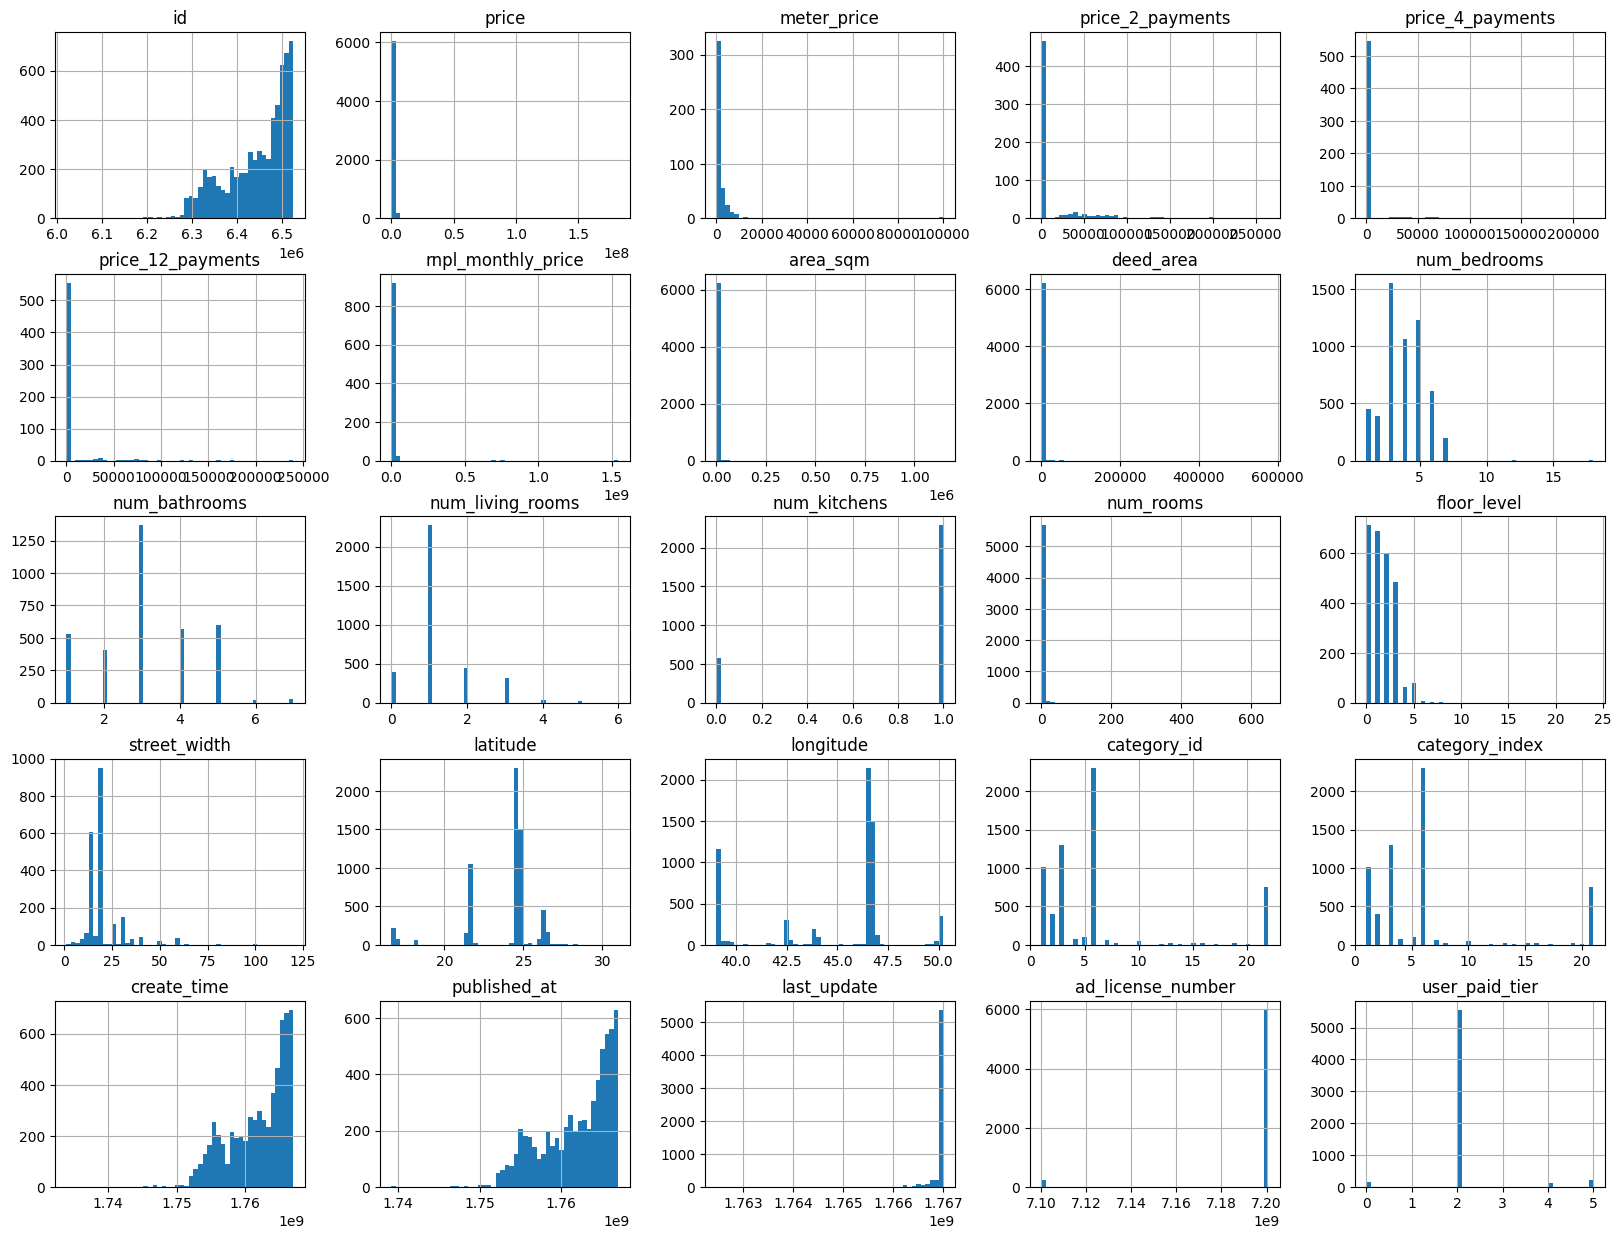

In [3]:
df.hist(bins=50, figsize=(20,15))

In [4]:
# show category_ga_property_category possible values
df['category_ga_property_category'].value_counts()


category_ga_property_category
apartment    3316
villa        1409
floor         759
land          426
building       87
flat           83
lounge         67
store          33
room           25
office         16
farm           16
warehouse      13
house           2
Name: count, dtype: int64

array([[<Axes: title={'center': 'area_sqm'}>,
        <Axes: title={'center': 'num_bedrooms'}>],
       [<Axes: title={'center': 'num_bathrooms'}>,
        <Axes: title={'center': 'price'}>]], dtype=object)

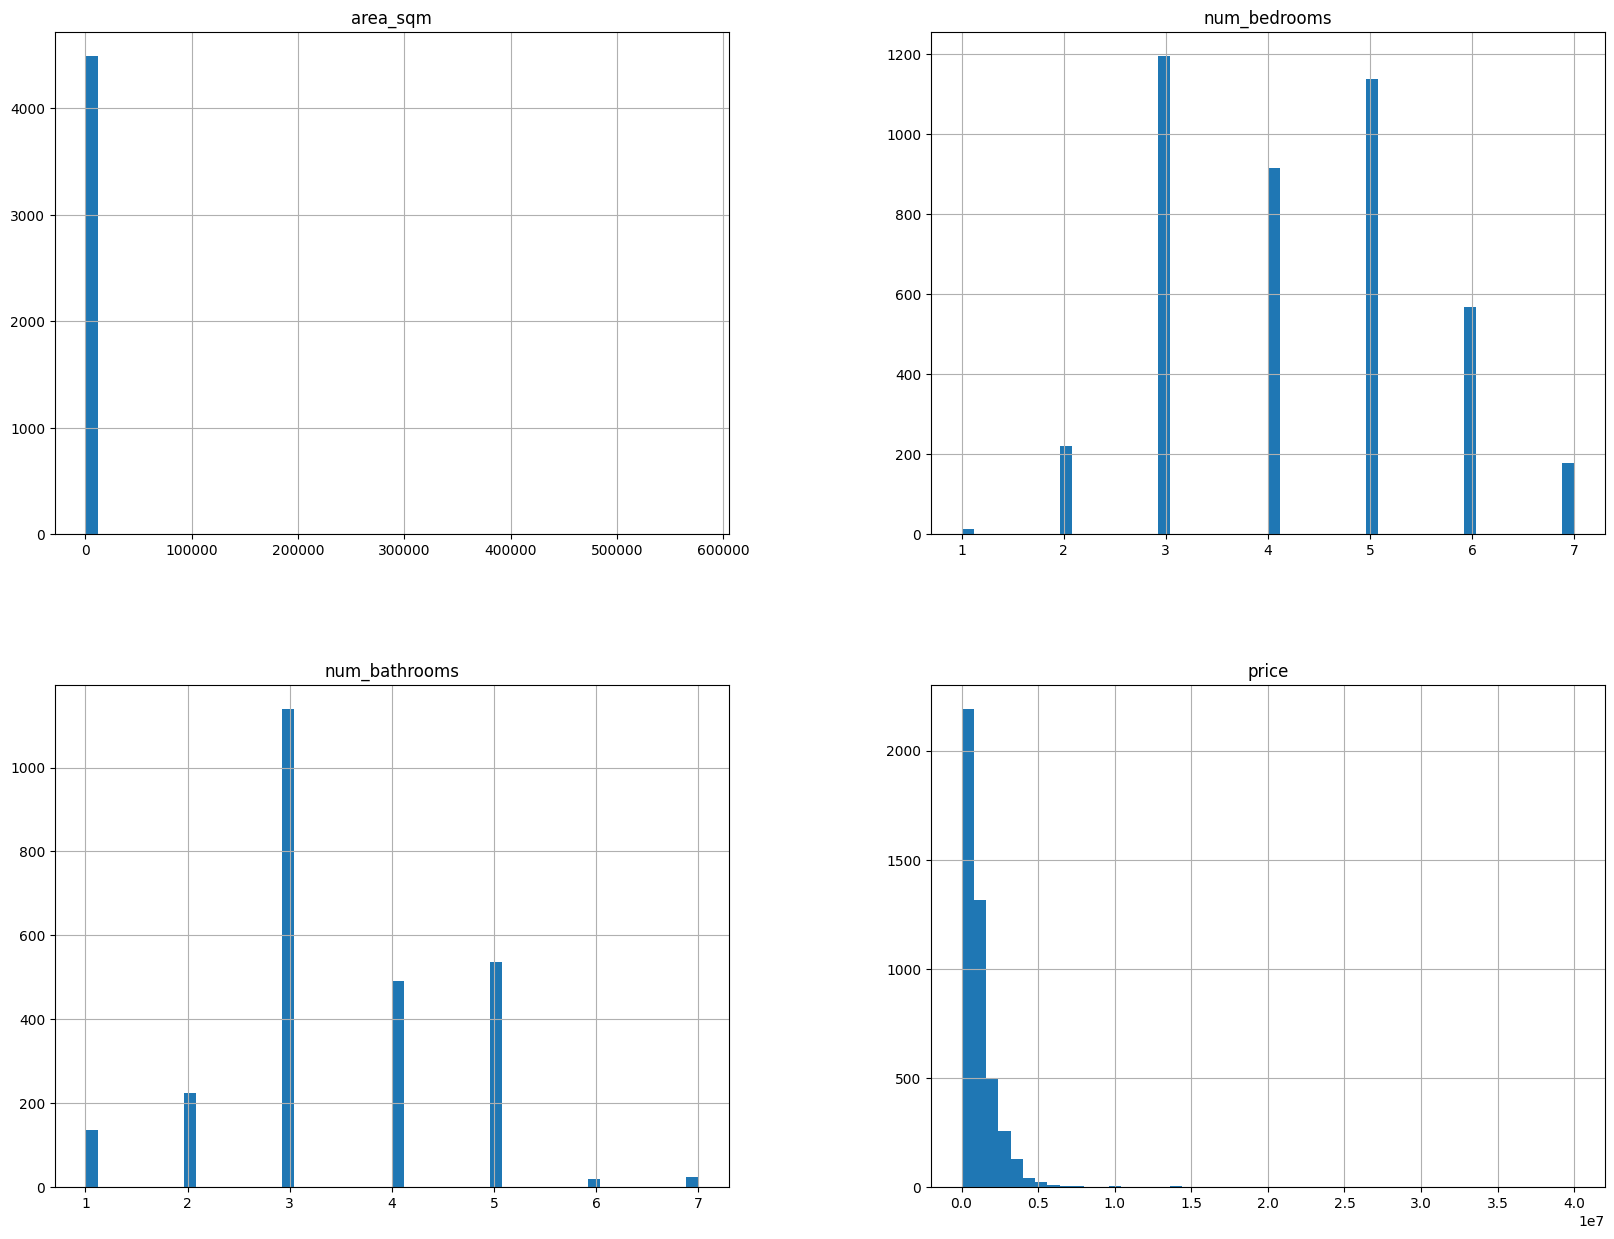

In [5]:
num_feature_cols=["area_sqm","num_bedrooms","num_bathrooms"]
cat_feature_cols=["district","city"]
bool_feature_cols=["lift"]

df = df[(df['is_rental'] == False) & (df['is_daily_rental'] == False) & (df['sale_type'] != 'rent') & (df['sale_type'] !='daily')].copy()
pd.set_option('future.no_silent_downcasting', True)
df[bool_feature_cols] = df[bool_feature_cols].fillna(False)
# drop listings of land without buildings
df=df[df['category_ga_property_category'] != 'land'].copy()
# drop listings of commercial buildings
df=df[(df["category_ga_listing_type"]!= "office") & (df["category_ga_listing_type"]!="store") & (df["category_ga_listing_type"]!="warehouse") & (df["category_ga_listing_type"]!="lounge")].copy()
target_col=["price"]

df[num_feature_cols + cat_feature_cols + bool_feature_cols + target_col].head()

df[num_feature_cols + cat_feature_cols + bool_feature_cols + target_col].hist(bins=50, figsize=(20,15))



In [6]:
for bool in bool_feature_cols:
    df[bool] = df[bool].astype(int)


In [9]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df[num_feature_cols + cat_feature_cols + bool_feature_cols + target_col], title="Aqar Dataset Profiling Report")
profile.to_widgets()

/home/azoz-laptop/Desktop/Git-Projects/W3/.venv/lib/python3.13/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)
Generate report structure: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


ValueError: ('widget type not understood', 'overview_tabs')

In [ ]:
df[num_feature_cols + cat_feature_cols + bool_feature_cols + target_col].head()

,area_sqm,num_bedrooms,num_bathrooms,district,city,lift,price
0,116.0,4.0,3.0,حي النرجس,الرياض,0,1500000.0
1,700.0,7.0,5.0,حي الملقا,الرياض,1,13500000.0
3,215.0,6.0,NaN,حي دره المنسك,ابها,0,635000.0
4,169.0,5.0,NaN,حي ابها الجديده,ابها,0,510000.0
5,208.0,6.0,NaN,حي القريقر,ابها,0,540000.0


In [ ]:
from sklearn.model_selection import train_test_split

# Drop rows with missing values in the selected columns
df = df.dropna(subset=num_feature_cols + cat_feature_cols + bool_feature_cols + target_col)

# One-hot encode the categorical columns (district and city)
df_encoded = pd.get_dummies(df[num_feature_cols + cat_feature_cols + bool_feature_cols + target_col], columns=cat_feature_cols, drop_first=True)

# Define features and target
X = df_encoded.drop(columns=target_col)
y = df_encoded[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Initialize and train the model
model = LinearRegression()
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}


grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

# Make predictions
y_pred = grid_search.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
model= grid_search.best_estimator_

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print("\nBest parameters:", grid_search.best_params_)
print("\nCoefficients:", grid_search.best_estimator_.coef_)
print("Intercept:", grid_search.best_estimator_.intercept_)


Mean Squared Error: 336903376994.7132
R^2 Score: 0.5379039892445645

Best parameters: {'fit_intercept': True, 'positive': False}

Coefficients: [[ 1.68538597e+03  1.68550855e+05  1.21959125e+05  1.13581842e+04
   1.05816684e+06  7.07975824e+05  2.39939431e+05  1.77875136e+06
   4.44782829e+05  1.04925818e+06  6.09733965e+05  2.52936101e+06
   2.12768652e+06  2.01307494e+05  1.62841718e+06  1.19951466e+06
   8.66848551e+05  2.44785925e+06  1.13025931e+06  1.02434883e+06
   7.62784747e+05  2.57072866e+05  1.30631824e+06  4.12319352e+05
   5.31865288e+05  8.84290785e-07 -7.88713805e-07  1.18543557e+06
   1.35537013e+06  2.34562241e+05  6.07403692e+04  2.17346557e+05
   1.00807001e+06  1.81999935e+06  5.68857156e+05 -9.97560549e+04
   6.83878175e+05  1.17994867e+06  7.81646134e+05  6.79282907e+06
   9.85911246e+05  1.35735852e+06  1.06763813e+06  7.88685913e+05
   9.55282506e+05  7.70454008e+05  1.19469536e+06  1.21934013e+06
   5.99202758e+05  5.85382000e+05 -1.23679638e-06  9.63448647e+0

In [ ]:
# grid search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train.values.ravel())

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [None, 10, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >

In [ ]:
model_rf = grid_search.best_estimator_
model_rf.fit(X_train, y_train.values.ravel())
y_pred_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Mean Squared Error: {mse_rf}")
print(f"Random Forest R^2 Score: {r2_rf}")

Random Forest Mean Squared Error: 235737821782.14896
Random Forest R^2 Score: 0.6766624662494367


In [ ]:
cross_val_scores = cross_val_score(model, X, y.values.ravel(), cv=5, scoring='r2')
print(f"Cross-validated R^2 scores: {cross_val_scores}")
print(f"Average Cross-validated R^2 score: {cross_val_scores.mean()}")

cross_val_scores_rf = cross_val_score(model_rf, X, y.values.ravel(), cv=5, scoring='r2')
print(f"Random Forest Cross-validated R^2 scores: {cross_val_scores_rf}")
print(f"Random Forest Average Cross-validated R^2 score: {cross_val_scores_rf.mean()}")


Cross-validated R^2 scores: [0.46221569 0.30701383 0.54065488 0.27389344 0.55846726]
Average Cross-validated R^2 score: 0.4284490194989126
Random Forest Cross-validated R^2 scores: [0.47741662 0.57419928 0.8089498  0.56000028 0.59737459]
Random Forest Average Cross-validated R^2 score: 0.6035881150707557
